## **Data preprocessing**

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


In [3]:
df_raw = pd.read_csv("C:/Users/Admin/Documents/Telewire.csv")
df = df_raw.copy()
df.head()

,id,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL_DL,Unusual
0,1,6:00,3BLTE,4.446,0.909,0.368,0.033,24.184,0.907,1.041,1.011,3.0,2.0,5,0
1,2,19:45,7VLTE,1.920,6.063,0.781,0.064,16.150,0.795,1.314,0.010,6.0,4.0,10,0
2,3,4:30,2ALTE,0.000,0.398,0.007,0.005,0.035,0.019,0.995,0.010,1.0,1.0,2,1
3,4,10:00,7VLTE,1.314,2.728,0.348,0.047,17.663,3.107,1.192,0.010,5.0,3.0,8,0
4,5,15:30,5BLTE,23.747,3.638,1.066,0.143,24.075,8.192,1.425,1.182,6.0,5.0,11,0


In [57]:
df.describe()


,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,Unusual
count,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36815.000000,36815.000000,36904.000000
mean,7.835090,2.106396,0.560525,0.067610,17.764369,1.791974,1.173441,0.665143,4.190819,3.063371,0.275932
std,8.428206,2.247514,0.727623,0.186555,15.739932,5.028928,0.214065,0.535493,1.772484,1.387446,0.446989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.213000,0.707000,0.140000,0.021000,5.710750,0.362000,1.041000,0.010000,3.000000,2.000000,0.000000
50%,4.547000,1.314000,0.352000,0.040000,14.170000,0.703000,1.112000,1.011000,4.000000,3.000000,0.000000
75%,12.126000,2.728000,0.718000,0.075000,25.059500,1.242000,1.263000,1.051000,5.000000,4.000000,1.000000
max,51.333000,77.505000,19.601000,12.461000,140.008000,48.253000,2.915000,2.668000,12.000000,12.000000,1.000000


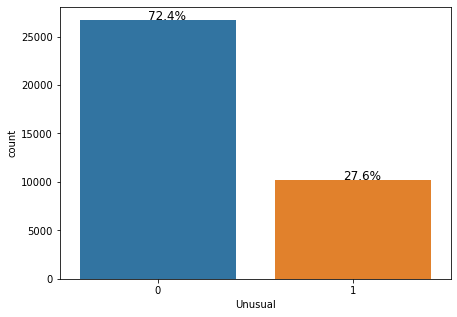

In [58]:
plt.figure(figsize=(7,5))
ax = sns.countplot(data=df, x='Unusual')
total = len(df)
for p in ax.patches:

    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)


In [59]:
n_normal= len(df[df.Unusual==0])
n_unusual= len(df[df.Unusual==1])

anomaly_fraction = n_unusual / n_normal
anomaly_fraction_2 = n_unusual /(n_unusual+ n_normal)

we have 27.2% Unusual cases in the Dataset which are anomalies

We explore the distribution of the Usual activities accross numerical features of the dataset.

Below we can see a visual representation of corresponding features categorized based on normal and Unusal activities.

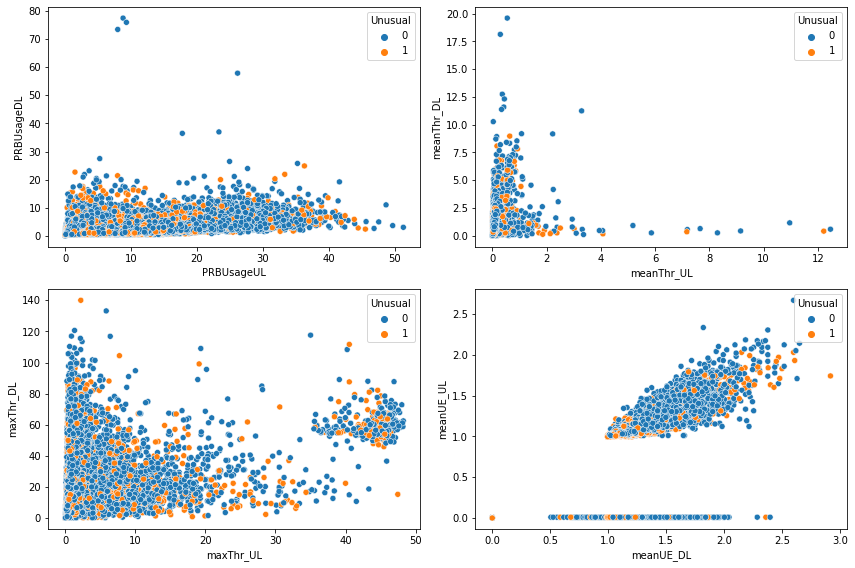

In [60]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
sns.scatterplot(ax=axs[0, 0], x="PRBUsageUL",y="PRBUsageDL",hue="Unusual",data=df)
sns.scatterplot(ax=axs[0, 1], x="meanThr_UL",y="meanThr_DL",hue="Unusual",data=df)
sns.scatterplot(ax=axs[1, 0], x="maxThr_UL",y="maxThr_DL",hue="Unusual",data=df)
sns.scatterplot(ax=axs[1, 1], x="meanUE_DL",y="meanUE_UL",hue="Unusual",data=df)
plt.tight_layout()

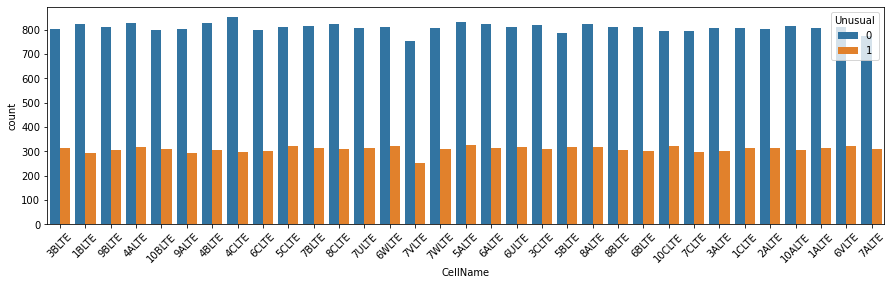

In [61]:
plt.figure(figsize=(15,4))
sns.countplot(x='CellName', data =df, hue ='Unusual')
plt.xticks(rotation=45);

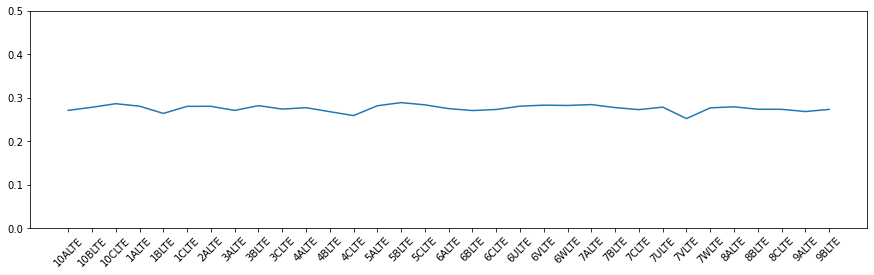

In [62]:
Series_Total = df.groupby("CellName")['Unusual'].count()
Series_Normal = df[df['Unusual']==0].groupby("CellName")['Unusual'].count()
Series_Unusual = df[df['Unusual']==1].groupby("CellName")['Unusual'].count()
plt.figure(figsize=(15,4))
plt.plot(Series_Unusual / Series_Total)
plt.ylim([0,0.5])
plt.xticks(rotation=45);

In [63]:
df = df.drop('CellName',axis=1)

## **Check for Missing Data**

Let's explore missing data columns. Following function list the missing values and their column names:

In [64]:
def missing_columns(dataframe):
    """
    Returns a dataframe that contains missing column names and 
    percent of missing values in relation to the whole dataframe.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    
    # find the missing values
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall size
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    
    # find Unusual missing values
    missing_values_Unusual = dataframe[dataframe['Unusual']==1].isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall Unusual cases
    missing_values_pct_Unusual = 100 * missing_values/len(dataframe[dataframe['Unusual']==1])
    
    # create a new dataframe which is a concatinated version
    concat_values = pd.concat([missing_values, missing_values_pct.round(1), missing_values_Unusual, missing_values_pct_Unusual.round(2)],axis=1)

    # give new col names
    concat_values.columns = ['Total Missings', 'Missing Count %','Total Missings (Unusual)', 'Missing Count (Unusual) %']
    
    # return the required values
    return concat_values[concat_values.iloc[:,1]!=0]

missing_columns(df)

,Total Missings,Missing Count %,Total Missings (Unusual),Missing Count (Unusual) %
maxUE_DL,89,0.2,16,0.87
maxUE_UL,89,0.2,16,0.87


There are ~0.3% data recording with missing values, among them there are 2 Unusual cases which is equivalent to 1% of Unusual cases. Considering that 27.2% of total dataset are Unusual cases, it makes sense to drop the rows with missing values.

In [65]:
print("The length of original data set = ", len(df))
df = df.dropna()
print("The length of data set with no missing values= ", len(df))

The length of original data set =  36904
The length of data set with no missing values=  36815


In [66]:
print("Number of missing value for each feature:")
print(df.isnull().sum())

Number of missing value for each feature:
Time           0
PRBUsageUL     0
PRBUsageDL     0
meanThr_DL     0
meanThr_UL     0
maxThr_DL      0
maxThr_UL      0
meanUE_DL      0
meanUE_UL      0
maxUE_DL       0
maxUE_UL       0
maxUE_UL+DL    0
Unusual        0
dtype: int64


In [67]:
df.fillna(value='', inplace=True)

## **Correlation Between Feature Variables**

Let's explore correlation between all continuous numeric feature variables using .corr() method. Correlation is a statistical measure that indicates the extent to which two or more variables fluctuate together. A positive correlation indicates the extent to which those variables increase or decrease in parallel; a negative correlation indicates the extent to which one variable increases as the other decreases

In [68]:
def tToSec(T):
    sec = 0
    value = T.split(":")
    sec += int(value[0])*60*60
    sec+= int(value[1])
    # print(sec)
    return str(sec)

df['Time'] = df['Time'].apply(tToSec)
# df = df.apply(df.to_numeric)
# df.corr()

## **Utilizing Heatmap to Visualize Correlation Between Feature Variables.**

<AxesSubplot:>

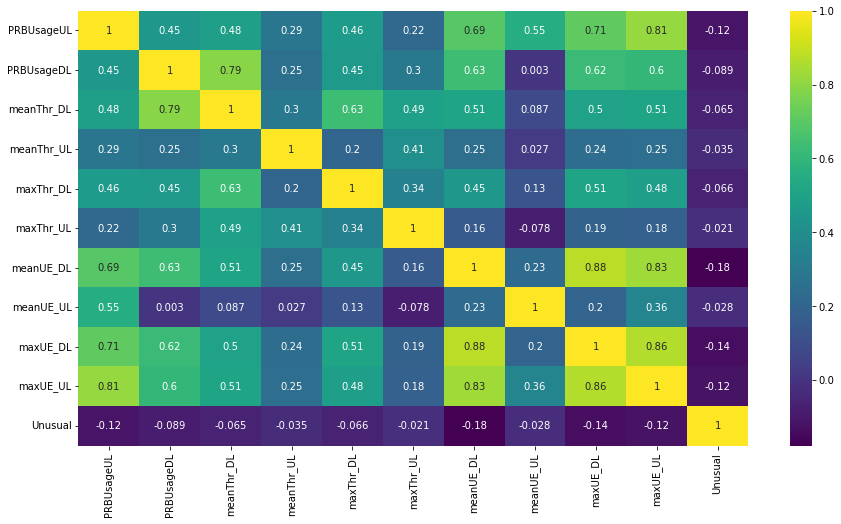

In [69]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

Based on the heatmap the following three features  which are maxUEDL, maxUEUL, and maxUE\_UL+DL are highly correlated. This is an indication of redundancy of features and that pose a potential risk to the accuracy of ML models.

In [70]:
df = df.drop('maxUE_DL',axis=1)

In [71]:
df = df.drop('maxUE_UL',axis=1)

In [72]:
df = df.drop('maxUE_UL+DL',axis=1)

<AxesSubplot:>

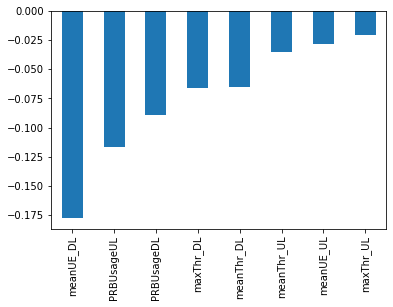

In [73]:
df.corr()['Unusual'].drop(labels=['Unusual']).sort_values().plot(kind='bar')

## **Checking for Outliers**

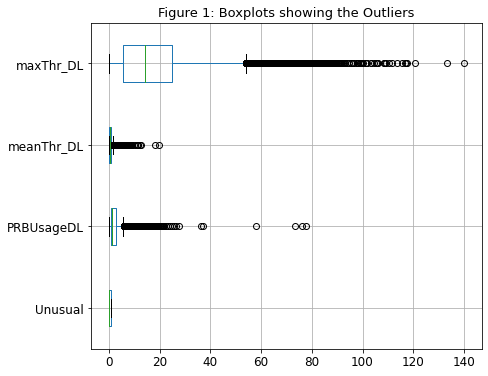

In [74]:
#there are few outliers for number of children.
i=1
df.boxplot(column=['Unusual', 'PRBUsageDL', 'meanThr_DL', 'maxThr_DL' ],vert = False, figsize=(7,6))
plt.title("Figure " + str(i) + ": Boxplots showing the Outliers",size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()
i=i+1




In [75]:
Q1 = df.quantile(0.25) #First Quartile
Q3 = df.quantile(0.75) #Third Quartile
IQR = Q3 - Q1

print('\nInterquartile Range is:')
print(IQR)

print('\nLower Outlier Boundarye is:')
print(Q1-(1.5*IQR))

print('\nUpper Outlier Boundarye is:')
print(Q3+(1.5*IQR))


Interquartile Range is:
PRBUsageUL    10.913
PRBUsageDL     2.021
meanThr_DL     0.578
meanThr_UL     0.054
maxThr_DL     19.343
maxThr_UL      0.880
meanUE_DL      0.222
meanUE_UL      1.041
Unusual        1.000
dtype: float64

Lower Outlier Boundarye is:
PRBUsageUL   -15.1565
PRBUsageDL    -2.3245
meanThr_DL    -0.7270
meanThr_UL    -0.0600
maxThr_DL    -23.3110
maxThr_UL     -0.9580
meanUE_DL      0.7080
meanUE_UL     -1.5515
Unusual       -1.5000
dtype: float64

Upper Outlier Boundarye is:
PRBUsageUL    28.4955
PRBUsageDL     5.7595
meanThr_DL     1.5850
meanThr_UL     0.1560
maxThr_DL     54.0610
maxThr_UL      2.5620
meanUE_DL      1.5960
meanUE_UL      2.6125
Unusual        2.5000
dtype: float64


## **Feature selection using z-test**

Here we move to do some hypthesis testing to find significant features.

So the case is we have to find if the values of unusual activities are significantly different  from normal activities or not for all features. We will be performing Z-test with normal activities as our population.

#### Hypothesis:

- H0: There is no difference (insignificant)
- H1: There is a difference (significant)

In [76]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = unusual[feature].std()
    zScore = (unusual[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [77]:
columns= df.drop('Unusual', axis=1).columns

normal= df[df.Unusual==0]
unusual= df[df.Unusual==1]

sample_size=len(unusual)
significant_features=[]
critical_value=1.960

for i in columns:
    print(i[1])

    # if ":" in i:
    #     print(i[1])
    # z_vavlue=ztest(i)
    
    # if( abs(z_vavlue) >= critical_value):    
    #     print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
    #     significant_features.append(i)
    # else:
    #     print(i," is rejected") #Reject Null hypothesis. i.e. H0

i
R
R
e
e
a
a
e
e


## **Feature Transformation**

In [78]:
X = (df.drop('Unusual', axis='columns'))
X_features = list(set(X.columns))
X = X.to_numpy()
y = (df['Unusual']).to_numpy()

In [79]:
#Let's now transform our data so that the distributions are closer to standard normal distributions. 
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

## **Split the Data**

We need to split the dataset into traning and testing sets. The training s set is used to evalet is used to fit the model, While the testing

So the case is we have to find if the values of unusual activities are significantly different  from normal activities or not for all features. We will be performing Z-test with normal activities as our population.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 50,stratify=y)
class_names = ['Normal', 'Unusual']

## **Train and Evaluate the model**

We need to fit the chosen algorithm to the training data. During this step the model learns the patterns in the data and creates a decision boundary that seperates the two classes.

In [81]:
#Model1 - random forest
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=20,random_state=2,max_depth=10)
rf.fit(X_train,y_train)
rfpred = rf.predict(X_test)
rfpred_conf_matrix = confusion_matrix(y_test,rfpred)
rf_acc_score = accuracy_score(y_test,rfpred)

print('Confussion matrix')
print(rfpred_conf_matrix,'\n')
print(classification_report(y_test,rfpred))
print('Accuracy of forest:', rf_acc_score)

Confussion matrix
[[7952   43]
 [1382 1668]] 

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      7995
           1       0.97      0.55      0.70      3050

    accuracy                           0.87     11045
   macro avg       0.91      0.77      0.81     11045
weighted avg       0.89      0.87      0.86     11045

Accuracy of forest: 0.8709823449524672


In [1]:
#Model2  -SVM

from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=2)
svc.fit(X_train,y_train)
svcpred = svc.predict(X_test)
svcpred_conf_matrix = confusion_matrix(y_test,svcpred)
svc_acc_score = accuracy_score(y_test,svcpred)


print(rfpred_conf_matrix,'\n')
print(classification_report(y_test,svcpred))
print('Accuracy of svc:', svc_acc_score)

NameError: name 'X_train' is not defined

In [83]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
desc_pred_conf_matrix = confusion_matrix(y_test, y_pred)
desc_acc_score = accuracy_score(y_test, y_pred)

print(desc_pred_conf_matrix, '\n')
print(classification_report(y_test, y_pred))
print('Accuracy of decision:', desc_acc_score)

[[7858  137]
 [ 176 2874]] 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7995
           1       0.95      0.94      0.95      3050

    accuracy                           0.97     11045
   macro avg       0.97      0.96      0.96     11045
weighted avg       0.97      0.97      0.97     11045

Accuracy of decision: 0.971661385242191


To choose between models , we can compare their F1 score and accuracy. The F1 score is a weighted average of precision and recall, which is useful when we have imbalanced classes. The accuracy on the other hand, measures the proportion of correct predictions out of all predictions. Based on the F1 score and accuracy, precision and recall we see random forest model performed best

In [84]:
#pip install xgboost

In [85]:
from xgboost import XGBClassifier
xgbcl = XGBClassifier(random_state=2022)

xgbcl.fit(X_train,y_train)
y_xgbcl = xgbcl.predict(X_test)
xgbclpred_conf_matrix = confusion_matrix(y_test,y_xgbcl)

print(xgbclpred_conf_matrix,'\n')
print("\nXGBoost: \n", classification_report(y_xgbcl,y_test))
print("XGBoost Accuracy: ", accuracy_score(y_xgbcl,y_test))


[17:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\Softwares\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[7984   11]
 [ 137 2913]] 


XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8121
           1       0.96      1.00      0.98      2924

    accuracy                           0.99     11045
   macro avg       0.98      0.99      0.98     11045
weighted avg       0.99      0.99      0.99     11045

XGBoost Accuracy:  0.9866002716161159


In [86]:
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn.model_selection import StratifiedKFold

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'n_estimators': [50, 65, 80, 100, 115, 130, 150,200,250,300,500,600,700,1000],
        'learning_rate': [0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
        'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]
        }


In [87]:
xgb = XGBClassifier(n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1, random_state = 2022)

folds = 2
param_comb = 5 

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 2022)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing 
# print('\n All results:')
# print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\Admin\Softwares\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 45.04 seconds.

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              impor

In [88]:
tunedxgbcl = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=10,
              monotone_constraints='()', n_estimators=1000,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=2022, reg_alpha=6.4)


tunedxgbcl.fit(X_train,y_train)
y_xgbcl = tunedxgbcl.predict(X_test)
tunepred_conf_matrix = confusion_matrix(y_test,y_xgbcl)

print(tunepred_conf_matrix, '\n')
print("\nXGBoost: \n", classification_report(y_xgbcl,y_test))
print("XGBoost Accuracy: ", accuracy_score(y_xgbcl,y_test))

[17:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_cat_to_onehot" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[7993    2]
 [ 390 2660]] 


XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98      8383
           1       0.87      1.00      0.93      2662

    accuracy                           0.96     11045
   ma

# Report Analysis

The tuned gradient boost appears not to doing better compared to the other models.  All four models are performing  good, but using the confusion matrix, the tuned gradient boost is not as better at predicting accurately for the 1-the unusual class.

# Neural Networks

In [89]:
from keras import backend as K
X_train1 = K.cast_to_floatx(X_train)
y_train1 = K.cast_to_floatx(y_train)

In [90]:
from sklearn.neural_network import MLPClassifier
    
cl = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

cl.fit(X_train1, y_train1)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1, solver='sgd')

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='sgd')

In [91]:
y_pred_n = cl.predict(X_train1)

In [92]:
f1_score(y_train1, y_pred_n)

0.0005614823133071308

In [93]:
accuracy_score(y_train1, y_pred_n)

0.723709740007761

In [94]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [95]:
from keras.models import Sequential
model = Sequential()


In [96]:
from keras.layers import Dense

In [97]:
# add first hidden layer
model.add(Dense(32,activation='relu',input_dim=9))

In [98]:
# Second hidden layer
model.add(Dense(16,activation='relu'))

In [99]:
# Output layer
model.add(Dense(1,activation='sigmoid'))

In [100]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [101]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

X_train = np.asarray(X_train).astype(np.float32)
y_traintrain = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [102]:
# Training for 200 epochs
model.fit(X_train,y_train,epochs=200)

Epoch 1/200
806/806 [==============================] - 1s 553us/step - loss: 50.6094 - accuracy: 0.6036
Epoch 2/200
806/806 [==============================] - 0s 541us/step - loss: 18.7606 - accuracy: 0.6088
Epoch 3/200
806/806 [==============================] - 0s 527us/step - loss: 13.8646 - accuracy: 0.6144
Epoch 4/200
806/806 [==============================] - 0s 529us/step - loss: 15.1037 - accuracy: 0.6125
Epoch 5/200
806/806 [==============================] - 0s 526us/step - loss: 12.7850 - accuracy: 0.6168
Epoch 6/200
806/806 [==============================] - 0s 503us/step - loss: 11.8837 - accuracy: 0.6155
Epoch 7/200
806/806 [==============================] - 0s 584us/step - loss: 10.4612 - accuracy: 0.6215
Epoch 8/200
806/806 [==============================] - 0s 536us/step - loss: 10.4166 - accuracy: 0.6169
Epoch 9/200
806/806 [==============================] - 0s 536us/step - loss: 12.4678 - accuracy: 0.6123
Epoch 10/200
806/806 [==============================] - 0s 525us

In [103]:
# Train and Test accuracy
scores = model.evaluate(X_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

806/806 [==============================] - 0s 427us/step - loss: 0.5854 - accuracy: 0.7250
Training Accuracy: 72.50%

346/346 [==============================] - 0s 627us/step - loss: 0.6073 - accuracy: 0.7228
Testing Accuracy: 72.28%

